In [1]:
from itertools import product
import numpy as np
from agent import *
from bandit import *
from policy import *
from tqdm.notebook import tqdm,trange
from IPython.utils import io
import scipy.stats as ss
import matplotlib.pyplot as plt

In [2]:
def generate_expert(bandit, i):
    #experts = [KernelUCB(bandit, GPUCBPolicy(), gamma=0.1,beta= 1000)]
    experts = [OracleExpert(bandit, GreedyPolicy())]
    return experts[i % len(experts)]

def generate_experts(n, bandit):
    return [generate_expert(bandit, i) for i in range(n)] 


In [3]:
def initialize_experiment(bandit,agents,experts,cache_id,n_prior_experiences,expert_spread,average_expert_distance,reset=True):
    if reset:
        bandit.reset()
        [e.reset() for e in experts]
    for agent in agents:
        agent.n = len(experts)
        agent.reset()
    
    if reset:
        agent.prior_play(experts,n_prior_experiences,expert_spread, bandit, average_expert_distance=average_expert_distance)
        
        # cache future contexts and predictions for efficiency
        bandit.cache_contexts(n_trials, cache_id) 
        for i, e in (enumerate(experts)):
            e.cache_predictions(bandit, n_trials) 

In [4]:
data=[]
n_experiments=1
K_N_configurations=((32,4),(4,32))
n_trials=1000
n_prior_experiences=100
average_expert_distances = (0,0.25,0.5,0.75,1)

expert_configurations = ('homogeneous','heterogeneous')

overall_bar = tqdm(total=n_trials*n_experiments*len(average_expert_distances)*len(K_N_configurations)*len(expert_configurations),smoothing=0,desc='Overal progress')
for experiment in  range(n_experiments):
    for ((n_arms,n_experts),average_expert_distance) in product(K_N_configurations,average_expert_distances):
        

        bandit = PerlinBandit(n_arms=n_arms,complexity=3)
        #bandit = DatasetBandit(family='adult'); assert n_arms==14

        experts = generate_experts(n_experts, bandit)
        for expert_conf in expert_configurations:
            
            
            #set up agents
            agents=[]
            agents += [Collective(bandit, GreedyPolicy(),n_experts,expert_spread = expert_conf)]
            
            #experts doubled for inversion trick
            agents += [MAB(bandit, GreedyPolicy(),n_experts*2,expert_spread = expert_conf)]
            agents += [Exp4(bandit, Exp3Policy(),n_experts*2,expert_spread = expert_conf,gamma=.5*(2*log(n_experts*2 + 1)/(n_arms * n_trials)) ** (1 / 2))]
            
            
            expected_regret = 8*(1+np.log(n_trials))
            sqcb_gamma = 100*(n_arms*n_trials/(expected_regret))**(1/2)
            agents += [SquareCB(bandit, SCBPolicy(),n_experts*2,expert_spread = expert_conf,gamma=sqcb_gamma)]
            
            agents += [LinUCB(bandit, GreedyPolicy(),n_experts,shared_model=True,expert_spread = expert_conf,alpha=1,beta=0)]
            
            overall_bar.set_description(f"Initializing experiment {experiment} N:{n_experts}, K:{n_arms}, Δ:{average_expert_distance}, {expert_conf} experts")
        
            # set up experiment (initializes bandits and experts)
            np.random.seed(experiment)
            initialize_experiment(bandit,agents,experts,experiment,n_prior_experiences,expert_conf,average_expert_distance,reset=True)

            overall_bar.set_description(f"Simulating experiment {experiment} N:{n_experts}, K:{n_arms}, Δ:{average_expert_distance}, {expert_conf} experts")
        
            # run experiment
            results = np.zeros((n_experts+len(agents)+2,n_trials))
            for t in range(n_trials):
                # Get current context and expert advice
                context = bandit.observe_contexts(cache_index=t)
                sampled_rewards = bandit.sample(cache_index=t)
                advice = np.array([e.value_estimates(cache_index = t,return_std=True) for e in experts])[:,0]
                
                # Choose action, log reward, and update each agent
                meta_context = {'advice':advice,'base':context}
                expanded_meta_context = {'advice':np.vstack([advice,1-advice]),'base':context}
                for n,agent in enumerate(agents):
                    if type(agent) in (MAB,Exp4,SquareCB): #invert trick
                        action = agent.choose(expanded_meta_context)
                    else:
                        action = agent.choose(meta_context)
                        
                    reward = sampled_rewards[action]
                    results[n_experts+n,t] = reward
                    agent.observe(reward, action, {})
                    

                # Log expert performance
                for e, expert in enumerate(experts):
                    choice = np.argmax(advice[e]) 
                    results[e,t] = sampled_rewards[choice]
                    
                results[-1,t]=np.max(bandit.action_values) #Best expected reward
                
                results[-2,t]=np.mean(bandit.action_values) #Random policy
                
                overall_bar.update()
            
            # log results
            for n,agent in enumerate(agents):
                agent_score = np.mean(results[n_experts+n])
                data.append([agent.short_name(),experiment,agent_score,"value",n_arms,n_experts,(n_arms,n_experts),expert_conf,average_expert_distance ])
            
            for sort_n,n in enumerate(sorted(range(n_experts),key=lambda n: np.mean(results[n]))):
                data.append([f"expert {sort_n}",experiment,np.mean(results[n]),"value",n_arms,n_experts,(n_arms,n_experts),expert_conf,average_expert_distance ])
            
            data.append([f"random",experiment,np.mean(results[-2]),"value",n_arms,n_experts,(n_arms,n_experts),expert_conf,average_expert_distance ])
            data.append([f"optimal",experiment,np.mean(results[-1]),"value",n_arms,n_experts,(n_arms,n_experts),expert_conf,average_expert_distance ])
        
            
overall_bar.close()

Overal progress:   0%|          | 0/20000 [00:00<?, ?it/s]

## Performance plots
We plot performance in function of performance below. In addition to the aggregation algorithms, the average performance of each expert is marked by a gray line.

In [5]:
import seaborn as sns 
import matplotlib.pyplot as plt
df = pd.DataFrame(data,columns=["algorithm","seed","average reward","advice type","K","N","(K,N)","configuration","Δ"])


(0, 1)

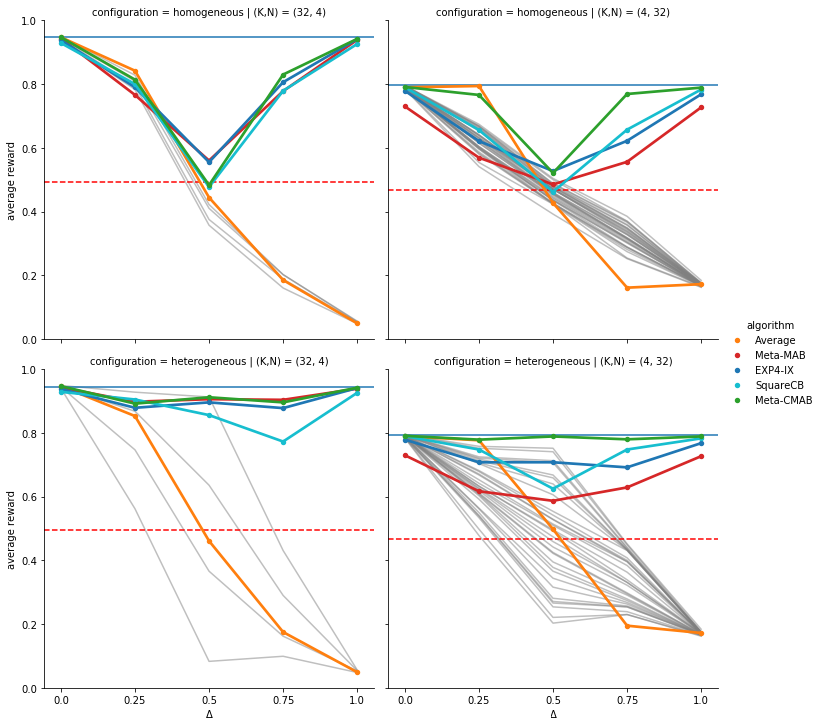

In [6]:
palette={'Average':'C1','EXP4-IX':'C0','Meta-CMAB':'C2','Meta-MAB':'C3','optimal':'grey','random':'red','SquareCB':'C9'}
g = sns.catplot(data=df[(~df.algorithm.str.contains("expert"))&(~df.algorithm.str.contains("optimal"))&(~df.algorithm.str.contains("random"))],y="average reward",x="Δ",hue="algorithm",palette=palette,kind='point',row="configuration",col_order=K_N_configurations,col='(K,N)',markers='.')

for ax_rows,row_name in zip(g.axes,expert_configurations):
    for ax,col_name in zip(ax_rows,K_N_configurations):
        subdf = df[(df['(K,N)']==col_name)&(df.algorithm.str.contains("expert"))&(df.configuration==row_name)].groupby(['algorithm','Δ']).mean()['average reward'].unstack().transpose()
        ax.plot(np.array(subdf.index)*(len(average_expert_distances)-1),subdf.values,c='grey',zorder=0,alpha=0.5)
        ax.axhline(df[(df['(K,N)']==col_name)&(df.algorithm.str.contains("optimal"))&(df.configuration==row_name)]['average reward'].mean(),zorder=0)
        ax.axhline(df[(df['(K,N)']==col_name)&(df.algorithm.str.contains("random"))&(df.configuration==row_name)]['average reward'].mean(),zorder=0,c='red',linestyle='--')
        
plt.ylim(0,1)